similarity search tutorial: https://www.youtube.com/watch?v=Rj9gSsB7kdw

k-means clustering tutorial: [How to cluster images based on visual similarity](https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
import base64
import io
from io import BytesIO
import cv2

from scipy import misc
from math import sqrt
from numpy import ndarray

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers.experimental.preprocessing import Resizing

from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# import the training dataset
apes_train = pd.read_csv("drive/My Drive/opencampus/DL course - NFT classifier/datasets/apes_train.csv")
#apes_train.head()
apes_train=apes_train['img']
apes_train.shape

(4612,)

# first we're building an image similarity search on the pixels comparison

original img size:  (500, 500)
resized img size:  49152
[[ 0]
 [ 0]
 [63]
 ...
 [63]
 [21]
 [ 0]]
img_test shape:  (49152, 1)


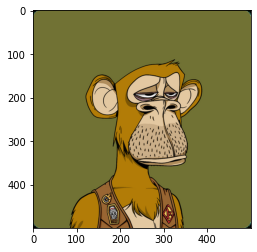

In [15]:
# import test image
apes_test = pd.read_csv("drive/My Drive/opencampus/DL course - NFT classifier/datasets/apes_test.csv")
#apes_test.head()

# set the desired size of image
x = 128
y=x*x*3

# decide the pictures that will be trained (all = len(apes_train))
quantity = 25
# and the one that will be tested on the dataset
pic_num = 100

# retreive test image from dataset
img_test=apes_test['img'][pic_num]
img_data = base64.b64decode(img_test[1:])
img_test = Image.open(io.BytesIO(img_data))
print("original img size: ",img_test.size)
img_test = np.array(img_test)
plt.imshow(img_test)
# apply gray filter to image
# img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)

# resize the test image
img_test = cv2.resize(img_test, (x,x))
print("resized img size: ",img_test.size)
# save resized image for later visualization
testimage=img_test
# reshape it for later use
img_test = np.reshape(img_test, [y,1],order="F")
print(img_test)


print("img_test shape: ",img_test.shape)

In [16]:
# loop through images in dataset and save it in the "dataset"-array
dataset = np.array([])

for i in range(quantity):
  save_data = dataset
  b64_img = apes_train[i][1:]
  img_data = base64.b64decode(b64_img)
  img = Image.open(io.BytesIO(img_data))
  img = np.array(img)
  #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # apply gray filter
  img = cv2.resize(img, (x,x))
  img = np.reshape(img, [1,img.size], order="F")
  i_save = i+1

  for k in range(len(img)):
    dataset = np.append(dataset,img)
  
print(i_save)

#reshape the dataset to make it comparable to the test images
dataset = np.reshape(dataset,[y,i_save],order="F")
print(dataset.shape)
print(dataset)

25
(49152, 25)
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.  57.  21.]
 [ 62.  79.  66. ...  72.  75.  90.]
 ...
 [ 91.  96.  83. ...  84. 100. 110.]
 [ 57.  57.  57. ...  21.  57.  57.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [17]:
#the function to compute the distance between the vectors of the images (pixel comparison)
def euclidean_distance(row1,row2):
  distance = 0.0
  for i in range(len(row1)):
    distance = distance + (row1[i] - row2[i])**2
  return sqrt(distance)

print("img3 len: ",len(dataset))
print("img_test len: ",len(img_test))

img3 len:  49152
img_test len:  49152


In [18]:
#compare the test picture to every picture in the dataset
dist = np.zeros(quantity)

for i in range(quantity):
  selectedimg = dataset[0:y,i]
  dist[i] = euclidean_distance(img_test,selectedimg)

print("Euclidean: ", dist)
print("Minimum dist: ", min(dist))
mindist = np.argmin(dist)
print("Index of min dist: ", mindist)

Euclidean:  [22540.23243003 10926.93090488 22654.21274289 24013.79851252
 23284.38242685 25621.79515569 16229.29983086 26769.5243514
 23533.08821638 23454.90181177 11256.15800351 25766.64698792
 27065.68554462  7763.69100364 22668.79374823 22301.47400958
 14836.76750509 13818.70127762 22487.85541131 27361.67275588
 23035.84537194 10851.20707571 12223.2399142   9792.28665839
 23799.61020689]
Minimum dist:  7763.691003639957
Index of min dist:  13


The test-image is most similar to the following picture: 


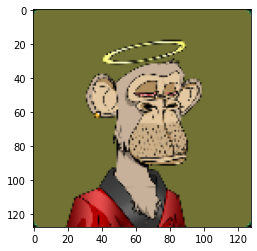

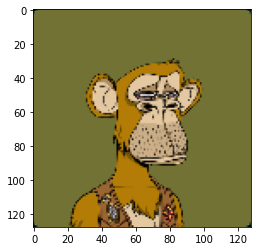

In [19]:
#pick the picture that's most similar and visualize it
img_data = base64.b64decode(apes_train[mindist][1:])
img = Image.open(io.BytesIO(img_data))
img = np.array(img)
img = cv2.resize(img,(x,x))
#img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

print("The test-image is most similar to the following picture: ")
plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(testimage)

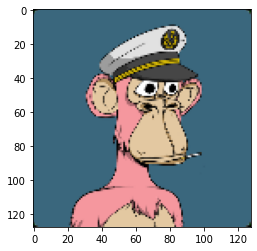

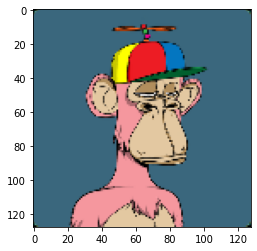

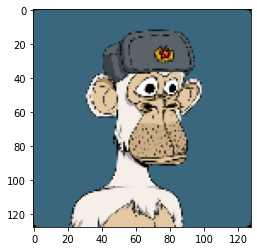

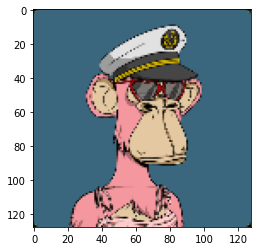

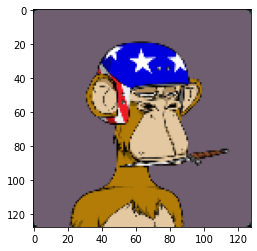

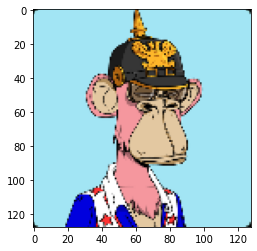

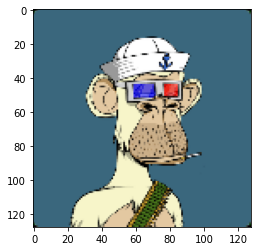

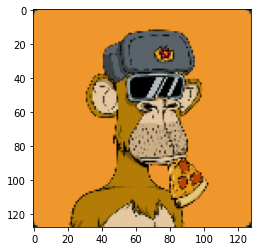

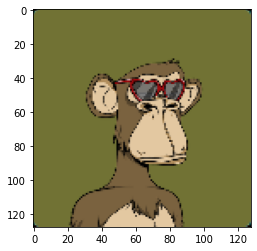

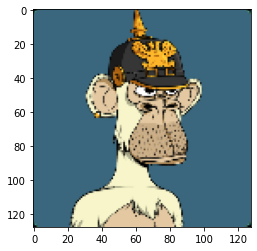

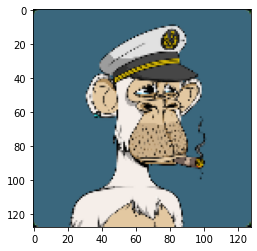

In [ ]:
for i in range(10):
  img_data = base64.b64decode(apes_train[mindist][1:])
  img = Image.open(io.BytesIO(img_data))
  img = np.array(img)
  img = cv2.resize(img,(x,x))
  plt.figure()
  plt.imshow(img)
  dist = np.delete(dist, mindist)
  mindist = np.argmin(dist)

plt.figure()
plt.imshow(testimage)

#### we suspect the pixels comparison method is biased by the pictures background on which it gives too much attention comparatively to other image features.

# we will use VGG16 model with pre-trained weight from imagenet dataset and run our image similarity search engine after passing images through our CNN. 

In [ ]:
# set the desired size of image
x = 128
y=x*x*3

# upload pretrained model
vgg = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(x,x,3))
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

original img shape:  (500, 500, 3)
vgg input img shape:  (1, 128, 128, 3)
vgg output img_test shape:  (1, 4, 4, 512)
img_test shape:  (8192, 1)


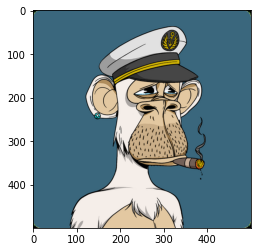

In [ ]:
# import test image and pass it through vgg16
apes_test = pd.read_csv("drive/My Drive/opencampus/DL course - NFT classifier/datasets/apes_test.csv")

# retreive test image from dataset
img_test = apes_test['img'][pic_num]
img_data = base64.b64decode(img_test[1:])
img_test = Image.open(io.BytesIO(img_data))
img_test = np.array(img_test)
print("original img shape: ",img_test.shape)
# visualize image
plt.imshow(img_test)
# transform image to fit vgg input
img_test = img_test[:,:,:3]
img_test = cv2.resize(img_test,(x,x))
img_test = img_test.reshape(1,x,x,3)
#img_test = preprocess_input(img_test)
print("vgg input img shape: ",img_test.shape)
img_test = vgg.predict(img_test)
print("vgg output img_test shape: ",img_test.shape)

# reshape vgg output to fit similarity comparison
img_test = np.reshape(img_test, [img_test.size, 1],order="F")
print("img_test shape: ",img_test.shape)

In [ ]:
# upload dataset
apes_train = pd.read_csv("drive/My Drive/opencampus/DL course - NFT classifier/datasets/apes_train.csv")

vgg_dataset = np.array([])
# loop through each image in the dataset
for i in range(quantity):
  b64_img = apes_train.img.loc[i][1:]
  img_data = base64.b64decode(b64_img)
  img = Image.open(io.BytesIO(img_data))
  img = np.array(img)
  # transform image to fit vgg input
  img = img[:,:,:3]
  img = cv2.resize(img,(x,x))
  img = img.reshape(1, x,x,3)
  #pass the image in vgg16 model
  img = vgg.predict(img)
  img = np.reshape(img, [1,img.size],order="F")
  i_save = i+1

  for k in range(len(img)):
    vgg_dataset = np.append(vgg_dataset, img)
  
#reshape the dataset to make it comparable to the test image
vgg_dataset = np.reshape(vgg_dataset,[img.size, i_save],order="F")
print(len(vgg_dataset))
print(vgg_dataset.shape)
print(vgg_dataset)

8192
(8192, 4612)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ... 10.10216808  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
#the function to compute the distance between the vectors of the images
def euclidean_distance(row1,row2):
  distance = 0.0
  for i in range(len(row1)):
    distance = distance + (row1[i] - row2[i])**2
  return np.sqrt(distance)

print("img3 len: ",len(vgg_dataset))
print("img_test len: ",len(img_test))

img3 len:  8192
img_test len:  8192


In [ ]:
#compare the test picture to every vgg processed picture in the dataset
dist = np.zeros(quantity)

for i in range(quantity):
  selectedimg = vgg_dataset[0:y,i]
  dist[i] = euclidean_distance(img_test,selectedimg)

print("Euclidean: ", dist)
print("Minimum dist: ", min(dist))
mindist = np.argmin(dist)
print("Index of min dist: ", mindist)

Euclidean:  [1218.54650879 1486.82409668 1391.34106445 ... 1574.24304199 1318.28491211
 1396.05041504]
Minimum dist:  804.89404296875
Index of min dist:  3935


The test-image is most similar to the following picture: 


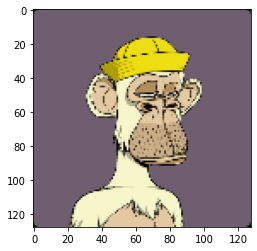

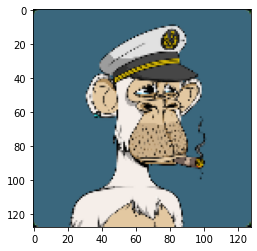

In [ ]:
# import test image and pass it through vgg16
apes_test = pd.read_csv("drive/My Drive/opencampus/DL course - NFT classifier/datasets/apes_test.csv")
#apes_test.head()

# retreive test image from dataset
img_test = apes_test['img'][pic_num]
img_data = base64.b64decode(img_test[1:])
img_test = Image.open(io.BytesIO(img_data))
img_test = np.array(img_test)

#pick the picture that's most similar image
img_data = base64.b64decode(apes_train.img.loc[mindist][1:])
img = Image.open(io.BytesIO(img_data))
img = np.array(img)
img = cv2.resize(img,(x,x))
#img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

print("The test-image is most similar to the following picture: ")
plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(testimage)

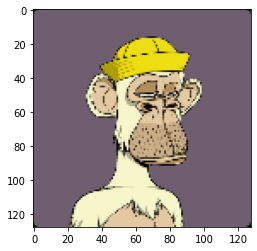

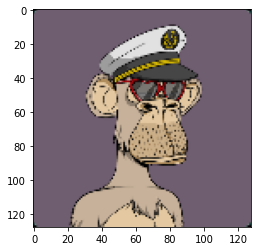

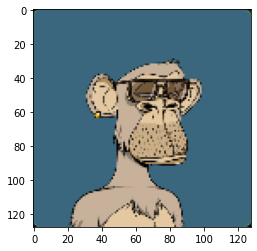

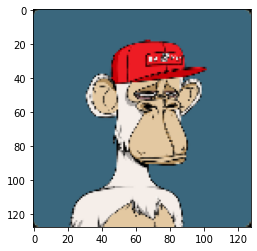

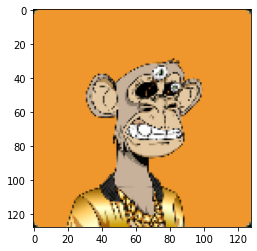

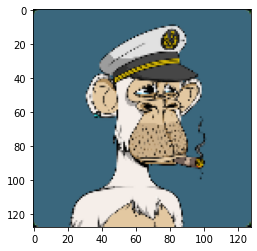

In [ ]:
for i in range(5):
  img_data = base64.b64decode(apes_train.img.loc[mindist][1:])
  img = Image.open(io.BytesIO(img_data))
  img = np.array(img)
  img = cv2.resize(img,(x,x))
  plt.figure()
  plt.imshow(img)
  dist = np.delete(dist, mindist)
  mindist = np.argmin(dist)

plt.figure()
plt.imshow(testimage)

Is the result the same with and without vgg16 processing?

In [ ]:
# try to check what the model gives as a result of a test image outside of the dataset (e.g solana)

In [ ]:
# performs k-means clustering on the images
kmeans = KMeans(n_clusters=40, random_state=22)
kmeans.fit(vgg_output)

NameError: ignored

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for cluster in kmeans.labels_:
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(cluster)
    else:
        pass

In [ ]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

### what's the best number of clusters for the apes collection?

running it takes lots of time.

result is: 

In [ ]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(1,40))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(vgg_output)
    
    sse.append(km.inertia_)

In [ ]:
# visualize the number of clusters
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [ ]:
# considering the slope, we should go for 40 cluster
